In [1]:
# Step 1: Import Libraries and Set Paths

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns 

In [2]:
# Set path to the FER-2013 training and test directories
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'


In [3]:
# Step 2: Data Preprocessing and Augmentation

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # MobileNet preprocessing
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% of training data for validation
)

# No augmentation for test set, only preprocessing
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",  # Convert grayscale to 3-channel RGB
    batch_size=32,
    class_mode="categorical",
    subset='training',  # Use the rest as training data
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset='validation',  # Validation split
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Verify the shape and classes

# Get a batch of images and labels
images, labels = next(train_generator)

# Print the shape of one batch of images and labels
print("Image batch shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
print("Label batch shape:", labels.shape)  # Should be (batch_size, num_classes)

# Print the number of classes detected
num_classes = train_generator.num_classes
print("Number of classes:", num_classes)

# Check class indices
print("Class indices:", train_generator.class_indices)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 7)
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# Define the model again with an explicit input shape for MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze batch normalization layers in the base model
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),  # Define input shape explicitly here
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 output classes
])

initial_learning_rate = 1e-4
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236,039 (12.34 MB)

 Trainable params: 3,192,263 (12.18 MB)

 Non-trainable params: 43,776 (171.00 KB)

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Filepath where the model will be saved
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=False,  # Only save the model if it improves
    mode='max',  # Looking for the maximum validation accuracy
    verbose=1  # Print messages when saving the model
)

# Calculate steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    verbose = 1,
    callbacks=[checkpoint_callback]
)



Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730862864.202654     120 service.cc:145] XLA service 0x7e3bec002090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730862864.202732     120 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730862864.202737     120 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/717 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.0781 - loss: 3.2072  

I0000 00:00:1730862874.871869     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.3559 - loss: 1.6269
Epoch 1: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 538s 723ms/step - accuracy: 0.3560 - loss: 1.6266 - val_accuracy: 0.5225 - val_loss: 1.2428
Epoch 2/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:14 105ms/step - accuracy: 0.6875 - loss: 0.9668

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6875 - loss: 0.9668 - val_accuracy: 0.6154 - val_loss: 1.2447
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5328 - loss: 1.2164
Epoch 3: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 381s 528ms/step - accuracy: 0.5328 - loss: 1.2163 - val_accuracy: 0.5307 - val_loss: 1.1600
Epoch 4/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:14 104ms/step - accuracy: 0.4688 - loss: 1.1091
Epoch 4: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.4688 - loss: 1.1091 - val_accuracy: 0.6923 - val_loss: 0.8886
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5748 - loss: 1.0999
Epoch 5: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 381s 527ms/step - accuracy: 0.5748 - loss: 1.0999 - val_accuracy: 0.5913 - val_loss: 1.0631
Epoch 6/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:14 103ms/step - accuracy: 0.5938 - loss: 1.02

In [7]:
# Load the best saved model
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on the validation  set
test_loss, test_accuracy = best_model.evaluate(validation_generator)
print(f"validation Accuracy: {test_accuracy:.4f}, validation Loss: {test_loss:.4f}")


180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 417ms/step - accuracy: 0.4918 - loss: 1.2849
validation Accuracy: 0.6015, validation Loss: 1.0601


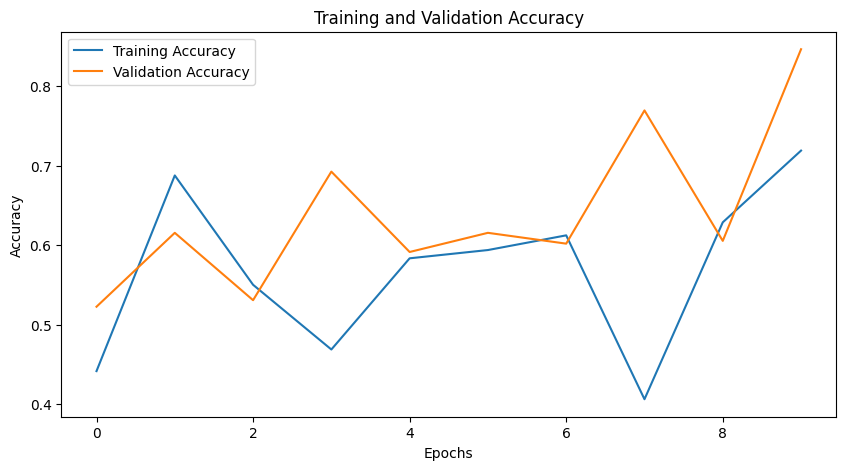

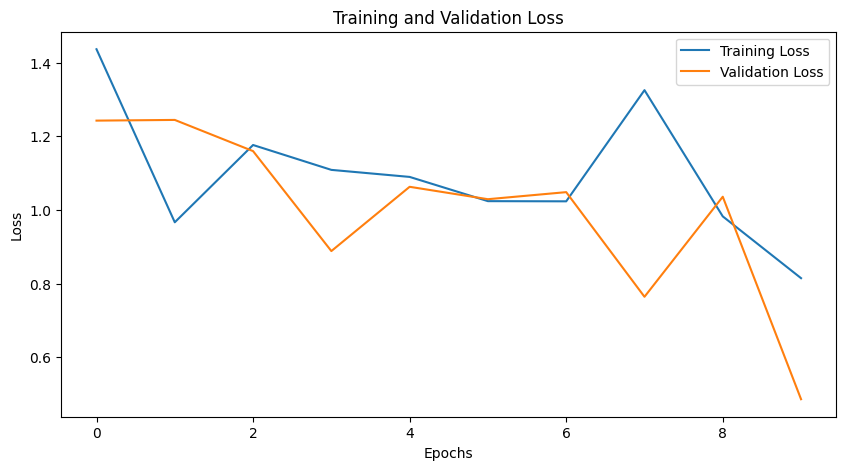

In [8]:
#learning curves
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [9]:
# Step 1: Unfreeze the top layers of MobileNet
for layer in base_model.layers[-100:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Step 2: Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 3: Define callbacks (reuse checkpoint and add early stopping for safety)
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to avoid overfitting during fine-tuning
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop if val_accuracy doesn’t improve for 5 epochs
    restore_best_weights=True
)

# Fine-tune the model
fine_tune_epochs = 10  # Set as needed
history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=fine_tune_epochs,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5149 - loss: 1.3339
Epoch 1: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 398s 525ms/step - accuracy: 0.5150 - loss: 1.3337 - val_accuracy: 0.5826 - val_loss: 1.1267
Epoch 2/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:28 124ms/step - accuracy: 0.6875 - loss: 0.8709
Epoch 2: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6875 - loss: 0.8709 - val_accuracy: 0.9000 - val_loss: 0.3754
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5955 - loss: 1.0705
Epoch 3: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 318s 439ms/step - accuracy: 0.5955 - loss: 1.0705 - val_accuracy: 0.5974 - val_loss: 1.0850
Epoch 4/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.4688 - loss: 1.4609
Epoch 4: saving model to best_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.4688 - loss: 1.4609 - val_accuracy: 0.9000 - val_loss: 0.3977


In [10]:
# Load the best saved model
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on the validation  set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"text Accuracy: {test_accuracy:.4f}, test Loss: {test_loss:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.5695 - loss: 1.1366
text Accuracy: 0.6148, test Loss: 1.0338


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report and confusion matrix
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))
print(confusion_matrix(y_true, y_pred_classes))


225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step
              precision    recall  f1-score   support

       angry       0.47      0.49      0.48       958
     disgust       0.29      0.04      0.06       111
        fear       0.43      0.27      0.33      1024
       happy       0.81      0.84      0.82      1774
     neutral       0.53      0.56      0.54      1233
         sad       0.44      0.52      0.47      1247
    surprise       0.69      0.72      0.71       831

    accuracy                           0.58      7178
   macro avg       0.52      0.49      0.49      7178
weighted avg       0.57      0.58      0.57      7178

[[ 466    3   91   57  111  203   27]
 [  55    4   12    6    4   27    3]
 [ 150    1  278   59  145  248  143]
 [  50    1   22 1485   97   70   49]
 [ 103    2   45   92  695  273   23]
 [ 141    2  121   80  231  650   22]
 [  30    1   81   57   38   23  601]]


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step


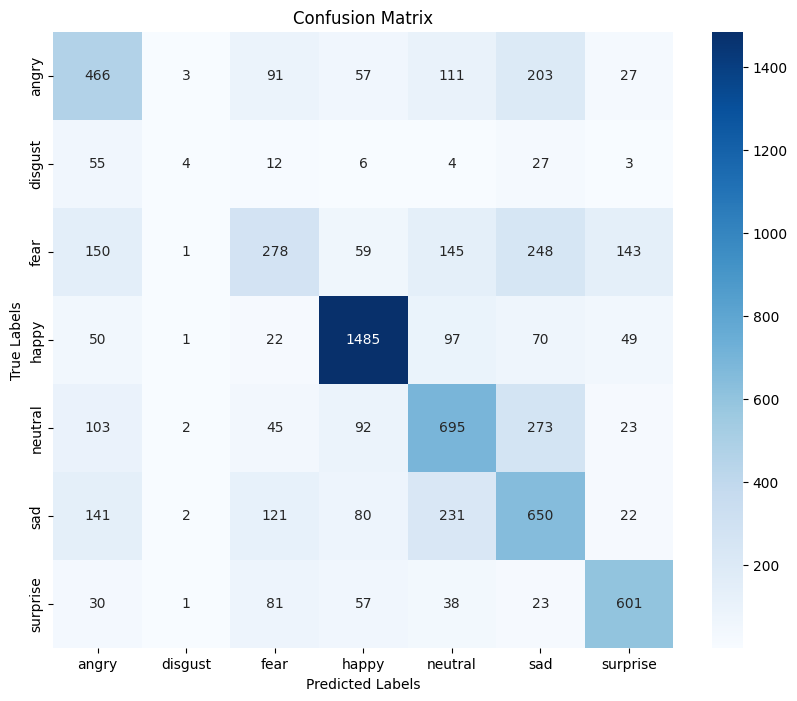

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


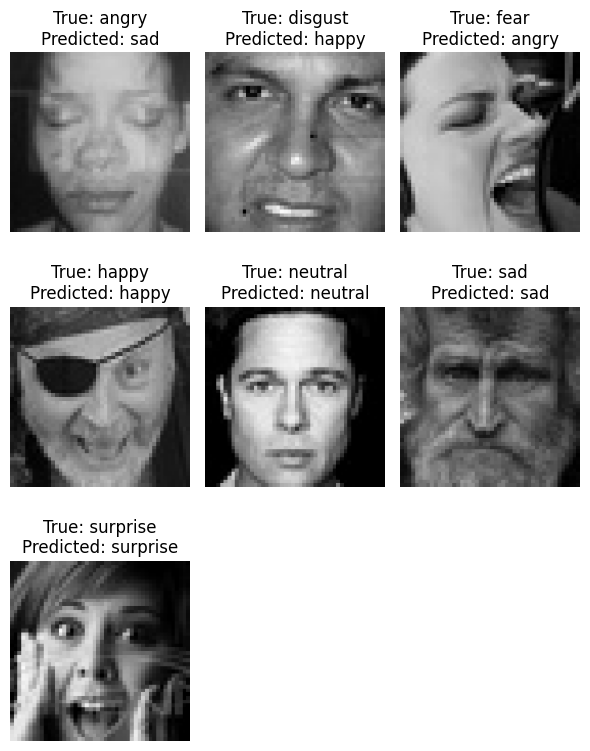

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get all images and labels from the test generator
test_images, test_labels = [], []
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    test_images.extend(images)
    test_labels.extend(labels)

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Make predictions on the entire test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Reverse preprocess (scale back to [0, 255] range)
test_images = ((test_images + 1) * 127.5).astype("uint8")

# Select one image per class
selected_images = []
selected_true_labels = []
selected_predicted_labels = []
for label in range(len(class_labels)):
    # Find indices where the true class matches the label
    indices = np.where(true_classes == label)[0]
    # Randomly choose one index for this label
    if len(indices) > 0:
        idx = np.random.choice(indices)
        selected_images.append(test_images[idx])
        selected_true_labels.append(class_labels[true_classes[idx]])
        selected_predicted_labels.append(class_labels[predicted_classes[idx]])

# Plot the selected images
plt.figure(figsize=(6, 8))
for i in range(len(selected_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i])  # Show as RGB without colormap
    true_label = selected_true_labels[i]
    predicted_label = selected_predicted_labels[i]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
